### Sources Used  
[Nueral networks theoretical explanation by 3Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
[Canvas artifical neural network - How to apply](https://fhict.instructure.com/courses/13413/pages/ann-how-to-apply?module_item_id=993448)
[Tensor flow image classification documentation](https://www.tensorflow.org/tutorials/images/classification)  
[Binding Of Isaac item dataset](https://www.kaggle.com/datasets/heidaran/binding-of-isaac-item-dataset?resource=download)

### Introduction
The Binding of Isaac is a single player rouge like game with over 700 unique collectible items, in this notebook ANN models from tensorflow keras will be explored to create an image classification model that can identify the unique items based on an image.

A classification model should work fairly well for this dataset, as the images it will have to classify are all generally the same, as the game is 2D with very static lighting, allowing for most instances of the items within an image to look very similar on a pixel basis.

The dataset used contains 200 artificially transformed images with the base images being extracted directly from the game files.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Set dataset values

In [3]:
dataset_directory = 'collectible-icons'
img_height = 32
img_width = 32

Load the dataset from directory, this should be 200 instances of 719 classes (719 items) according to the [BOI wiki in repentance V1.7.5](https://bindingofisaacrebirth.fandom.com/wiki/Items)

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(dataset_directory, labels='inferred', seed=123)

Found 143800 files belonging to 719 classes.


Check an example sample of the dataset images, to get a better idea of the images we are working with

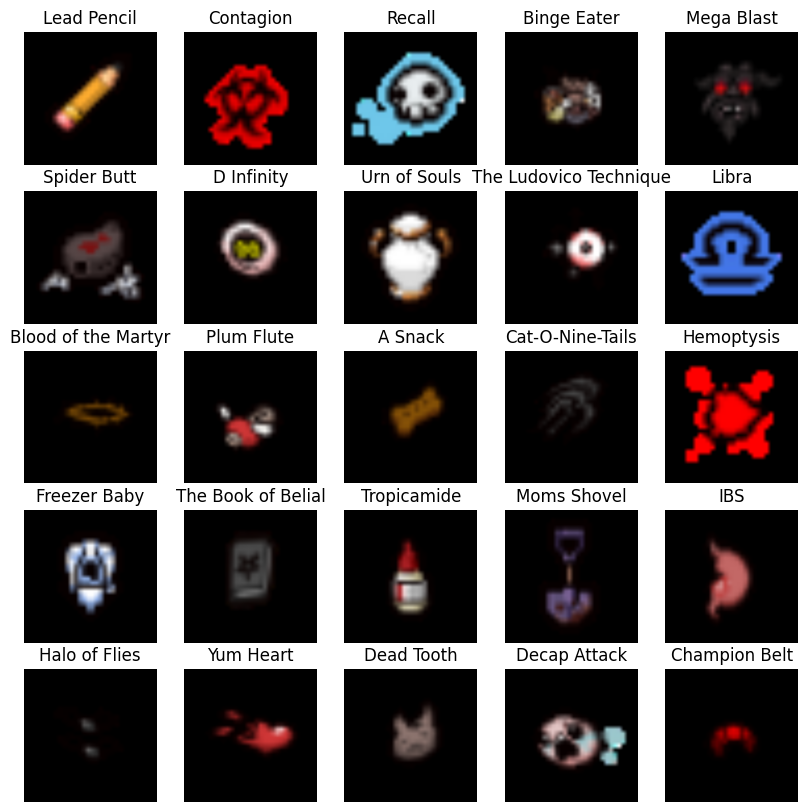

In [6]:
plt.figure(figsize=(10, 10))
class_names = dataset.class_names
for images, labels in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Create the actual train and test datasets, these will have a 4:1 split of train:test
Ensure that the same seed is used, as otherwise the dataset will be shuffled between splits, and some images might be excluded in duplicated

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

Found 143800 files belonging to 719 classes.
Using 115040 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

Found 143800 files belonging to 719 classes.
Using 28760 files for validation.


Cache the datasets to reduce disk operation load (otherwise tensor flow might block the files while using the dataset, as it is still reading from the source files)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Compile the first model  
This model Performs a rescaling operation to convert the 3 RGB values into a range of 0-1, as this should improve model performance
(This approach is slightly more efficient than applying the layer on the data itself, due to some internal conversions tensor flow will make to the data beforehand)

This model contains 4 layers, with 2 hidden layers as follows
```
(Pixel RGB values)                      (Flattened layer from R, G, B to single value)
| ⎴  |              | ⎴  |              | ⎴  |                | ⎴  |
| •  |              | •  |              | •  |                | •  |
| •  |              | •  |              | •  |                | •  |
|1024|x3     ->     | 16 |x3     ->     | 32 |       ->       |719 |
| •  |              | •  |              | •  |                | •  |
| •  |              | •  |              | •  |                | •  |
| ⎵  |              | ⎵  |              | ⎵  |                | ⎵  |
             (Specified neuron layer for R, G, B value)       (Classification layer for each class)
```

In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Perform 4 iterations of the model

In [16]:
epochs=4
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
3595/3595 [==============================] - 93s 24ms/step - loss: 2.4114 - accuracy: 0.4737 - val_loss: 1.2407 - val_accuracy: 0.6911
Epoch 2/4
3595/3595 [==============================] - 30s 8ms/step - loss: 0.8655 - accuracy: 0.7780 - val_loss: 0.6611 - val_accuracy: 0.8242
Epoch 3/4
3595/3595 [==============================] - 31s 9ms/step - loss: 0.5015 - accuracy: 0.8664 - val_loss: 0.4242 - val_accuracy: 0.8861
Epoch 4/4
3595/3595 [==============================] - 33s 9ms/step - loss: 0.3372 - accuracy: 0.9085 - val_loss: 0.3000 - val_accuracy: 0.9192


Graph the accuracy and loss (cost) of the train and validation data across the iterations

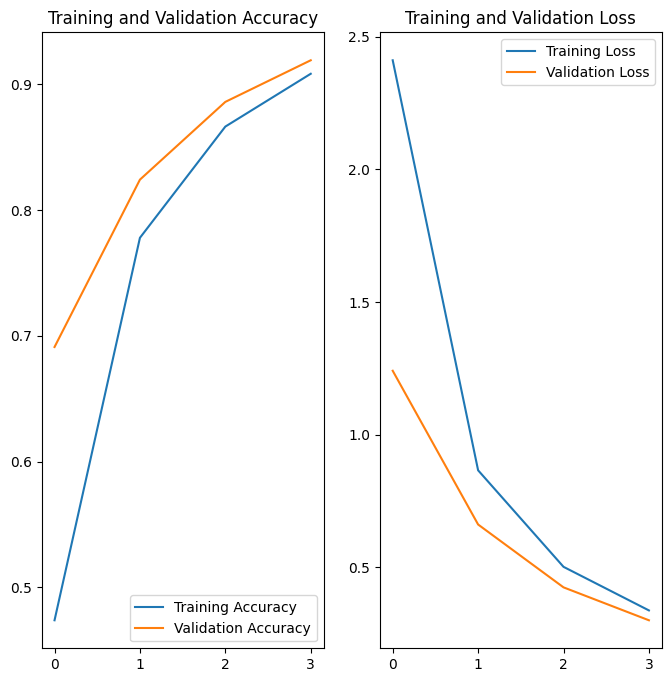

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()